# Loading checkpoint of trained model

In [1]:
import torch

In [2]:
ckpt = torch.load('results/bV5_big_new/default_1/ckpt.pt')

In [3]:
ckpt

{'args': Namespace(J_weight=32.0, L0=None, anneal_steps=12, bV_dim=5, batch_normalize_loss=False, batch_size=512, boundary_amp_scale=0.5, boundary_freq_scale=10.0, c1=0.0, c1_high=0.1, c1_low=-0.1, c2=0.0, c2_high=0.1, c2_low=-0.1, clip_grad_norm=0.01, dagger=False, data_name='bV5_big_new', deploy=True, deploy_error_alpha=0.9, experiment_name='default', ffn_layer_sizes='[256,128,64,32]', fix_normalizer=True, force_amp_scale=0.0, force_freq_scale=0.0, init='xavier', log_scale=True, lr=0.0003, max_collectors=0, max_evaluators=24, max_newton_iter=50, max_train_steps=10000000, metamaterial_mesh_size=80, min_feature_size=0.15, n_cells=2, n_safe=500, nonlinearity='selu', normalizer_alpha=0.999, optimizer='amsgrad', poisson_ratio=0.49, pore_radial_resolution=100, porosity=0.5, quadratic_scale=True, relaxation_parameter=0.5, reload_data=True, remove_rigid=True, results_dir='results', run_local=True, sample_c=False, seed=0, semipolarize=True, solve_adam_stepsize=0.01, solve_lbfgs_steps=100, sol

# Imports

In [4]:
from src.arguments import parser
from src import fa_combined as fa
from src.pde.metamaterial import Metamaterial
from src.maps.function_space_map import FunctionSpaceMap
from src.nets.feed_forward_net import FeedForwardNet
from src.energy_model.surrogate_energy_model import SurrogateEnergyModel
from src.energy_model.composed_energy_model import ComposedEnergyModel
from src.energy_model.composed_fenics_energy_model import ComposedFenicsEnergyModel

# Collect args from checkpoint

In [5]:
args = ckpt['args']

# Construct PDE and fsm. Reload net from checkpoint

In [6]:
pde = Metamaterial(args)
fsm = FunctionSpaceMap(pde.V, args.bV_dim, cuda=True)
net = FeedForwardNet(args, fsm)
net = net.cuda()
net.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

# Create Energy Models for composed-cell deployment

In [7]:
import numpy as np

RVES_WIDTH = 2

sem = SurrogateEnergyModel(args, net, fsm)
cem = ComposedEnergyModel(args, sem, RVES_WIDTH, RVES_WIDTH)

cfem = ComposedFenicsEnergyModel(args, RVES_WIDTH, RVES_WIDTH,
                                 np.zeros(RVES_WIDTH*RVES_WIDTH),
                                 np.zeros(RVES_WIDTH*RVES_WIDTH))

# Construct constraints

In [8]:
cem_constraint_mask = torch.zeros(len(cem.global_coords))
cem_constraint_mask[cem.bot_idxs()] = 1.0
cem_constraint_mask[cem.top_idxs()] = 1.0
force_data = torch.zeros(len(cem.global_coords), 2)
constrained_sides = [True, False, True, False]


MAX_DISP = 0.1

boundary_data = torch.zeros(len(cem.global_coords), 2)
boundary_data[cem.top_idxs(), 1] = RVES_WIDTH * MAX_DISP
params = torch.zeros(RVES_WIDTH*RVES_WIDTH, 2)

# Do surrogate solve

In [9]:
surr_soln = cem.solve(params.cuda(), boundary_data.cuda(),
                      cem_constraint_mask.cuda(), force_data.cuda())

# Do Fenics solve. This might take some time.

In [10]:
init_guess = np.array(fa.Function(cfem.pde.V).vector()[:])


# Tune anneal steps and relaxation parameter to get max speed without solution blowing up
ANNEAL_STEPS = 3
args.relaxation_parameter = 0.9

# This will make Fenics print solve progress
# (But it prints to the bash session running Jupyter, not this notebook)
fa.set_log_level(20)

for i in range(ANNEAL_STEPS):
    print("Anneal {} of {}".format(i+1, ANNEAL_STEPS))
    fenics_boundary_fn = fa.Expression(('0.0', 'X*x[1]'),
                                   element=pde.V.ufl_element(),
                                    X=MAX_DISP*(i+1)/ANNEAL_STEPS)

    true_soln = cfem.solve(args=args, boundary_fn=fenics_boundary_fn,
                           constrained_sides=constrained_sides,
                           initial_guess=init_guess)
    init_guess = true_soln.vector()
    

Anneal 1 of 3
Anneal 2 of 3
Anneal 3 of 3


In [11]:
true_soln

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 207), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2)), 393)

In [12]:
surr_soln

tensor([[ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [-3.2527e-03,  2.2466e-02],
        [ 7.5120e-05,  5.1332e-02],
        [-5.9840e-03,  7.4438e-02],
        [-2.8687e-03,  1.0178e-01],
        [ 1.1437e-02,  1.0397e-01],
        [ 1.3740e-02,  1.0343e-01],
        [ 1.9059e-02,  9.6113e-02],
        [ 3.1009e-02,  9.2395e-02],
        [ 3.0526e-02,  6.9977e-02],
        [ 3.3864e-02,  4.1063e-02],
        [ 3.1118e-02,  3.3672e-02],
        [ 5.7167e-04,  1.3004e-01],
        [ 6.4278e-03,  1.5265e-01],
        [-2.7010e-03,  1.8059e-01],
        [ 0.0000e+00,  2.0000e-01],
        [ 0.0000e+00,  2.0000e-01],
        [ 0.0000e+00,  2.0000e-01],
        [ 0.0000e+00,  2.0000e-01],
        [ 0.0000e+00,  2.0000e-01],
        [ 2.1552e-02,  1.6738e-01],
        [ 3.0521e-02,  1.3596e-01],
        [ 4.7380e-02,  1.2918e-01],
        [ 0.0000e+00,  0.000

# Plot the reference, true solution, and surrogate solution

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

initial_coords = np.array(cem.global_coords)

surr_final_coords = np.array(cem.global_coords) + surr_soln.data.cpu().numpy()

true_final_coords = initial_coords + np.array([true_soln(*x) for x in initial_coords])

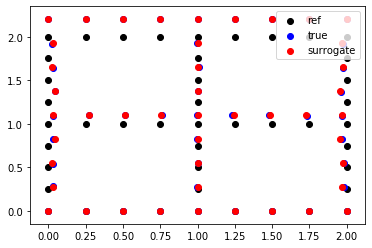

In [15]:
plt.scatter(initial_coords[:, 0], initial_coords[:, 1], color='k', label='ref')
plt.scatter(surr_final_coords[:, 0], surr_final_coords[:, 1], color='b', label='true')
plt.scatter(true_final_coords[:, 0], true_final_coords[:, 1], color='r', label='surrogate')
plt.legend()
plt.show()